# Modeling Diabetes Risk from BRFSS (2019–2023)

## 1. Introduction

Diabetes affects over 11% of the U.S. population and contributes significantly to healthcare costs and complications. Early detection and prevention are critical, especially when simple lifestyle changes can reduce risk.

This project uses data gathered annually by the U.S. Centers for Disease Control and Prevention (CDC). We include CDC’s Behavioral Risk Factor Surveillance System (BRFSS) survey data spanning 2019 to 2023. Our goal is to build a predictive model that identifies individuals at risk of diabetes based on demographic and behavioral features.

This is framed as a binary classification task: predicting whether a respondent has diabetes (`Yes`) or not (`No`). The dataset is large but imbalanced, and varies slightly across years in feature availability and structure.

We focus in this notebook on logistic regression baseline, followed by advanced models such as XGBoost in a second notebook. Along the way, we apply feature engineering, threshold tuning, and model interpretation to improve performance and trust.

Let’s begin by loading and inspecting the data.

In [1]:
# ⬇️ Colab setup: install lightweight requirements
try:
    import google.colab
    !pip install -q -r https://raw.githubusercontent.com/shaolinpat/brfss_diabetes_modeling/main/requirements-colab.txt
except ImportError:
    pass  # Not running in Colab

In [ ]:
%matplotlib inline
import sys
import os

# Adds the project root to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import time

from imblearn.over_sampling import SMOTE
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

from brfss_diabetes import clean_brfss

ImportError: cannot import name 'clean_brfss' from 'brfss_diabetes' (/home/pbeach/Dropbox/VT-MIT/Projects/brfss_diabetes_modeling/brfss_diabetes/__init__.py)

In [3]:
# Globals
SEED = 22
start_time = time.time()

# Detect if running in Google Colab
IN_COLAB = "google.colab" in sys.modules

# Set paths
if IN_COLAB:
    image_dir = Path("images")
    reports_dir = Path("reports")
    data_dir = Path("data/")
else:
    image_dir = Path("..") / "images"
    reports_dir = Path("..") / "reports"
    data_dir = Path("..") / "data/cleaned"

# Ensure that directories exist
os.makedirs(image_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

## 2. Load the Cleaned Dataset

### Origin of the BRFSS `.XPT` Files

The raw BRFSS datasets (SAS Transport files, `.XPT`) for 2019–2023 were downloaded directly from the CDC’s official Behavioral Risk Factor Surveillance System (BRFSS) site:

**CDC BRFSS Annual Survey Data**  
https://www.cdc.gov/brfss/annual_data/annual_data.htm

Initial processing of the data using `scripts/load_data.py` reduced the size from ~1GB per year to ~25MB per year. It does this by narrowing the columns to those that seem especial pertinent to predicting whether the person has diabetes or not.  Some of the feature columns are common across all years, and others are common to only some years. Thus, some csv files have 11 feature columns and some have 12. We store the resulting trimmed down datasets in `data/subset/`.

The subsetted files were cleaned and standardized using `scripts/clean_data.py`. There are two primary tasks in cleaing.  The first task is to ensure that like columns are named consistently the datasets for each year. Second, rows which have NaN values for the target column ("diabetes") are dropped since this is a task of supervised learning.

The cleaned datasets are stored in `../data/cleaned/` and merged into a single DataFrame for unified processing.

Since not all features are available in every year, we will later restrict our analysis to a consistent subset of columns shared across all years.


In [4]:
years = [2019, 2020, 2021, 2022, 2023]

dfs = []

for year in years:
    file = data_dir / f"brfss_cleaned_{year}.csv"
    print(f"Loading {file}")
    df = pd.read_csv(file, low_memory=False)

    # Move 'diabetes' column to the end if it's present
    if "diabetes" in df.columns:
        cols = [col for col in df.columns if col != "diabetes"] + ["diabetes"]
        df = df[cols]
    
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Make sure the target column 'diabetes' is at the end
target = "diabetes"
cols = [col for col in df_all.columns if col != target] + [target]
df_all = df_all[cols]

print(f"\nMerged shape: {df_all.shape}\n")
print(df_all.head())

Loading ../data/cleaned/brfss_cleaned_2019.csv
Loading ../data/cleaned/brfss_cleaned_2020.csv
Loading ../data/cleaned/brfss_cleaned_2021.csv
Loading ../data/cleaned/brfss_cleaned_2022.csv
Loading ../data/cleaned/brfss_cleaned_2023.csv

Merged shape: (2132659, 14)

   year   age     sex             educa    bmi     bmi_cat drink_any  \
0  2019  85.0  Female      Less than HS  28.17  Overweight        No   
1  2019  72.0  Female      Some college  18.54      Normal        No   
2  2019  67.0  Female  College graduate  31.62       Obese        No   
3  2019  85.0  Female      Some college  20.30      Normal       NaN   
4  2019  85.0  Female      Some college  21.48      Normal        No   

       fruit_low  veg_servings snap_used smoke_100 exercise_any  \
0  >= 1x per day          1.14       NaN       Yes           No   
1  >= 1x per day          1.21       NaN        No          Yes   
2  >= 1x per day          1.64       NaN        No          Yes   
3            NaN           NaN    

## 3. Exploratory Data Analysis (EDA)

### 3.1 Missing Values Summary

Before modeling, it's critical to understand the presence and pattern of missing data. Below, we identify which columns in the combined dataset (`df_all`) contain missing values, followed by a heatmap to show their distribution.

In [5]:
# Summarize missing values by column
missing_summary = df_all.isnull().sum()
missing_summary[missing_summary > 0].sort_values(ascending=False)

food_insecurity    1658655
snap_used          1629434
veg_servings       1393952
fruit_low          1372646
bmi                 212219
bmi_cat             212105
drink_any           155899
smoke_100           120219
age                  40374
exercise_any         25516
educa                10259
dtype: int64

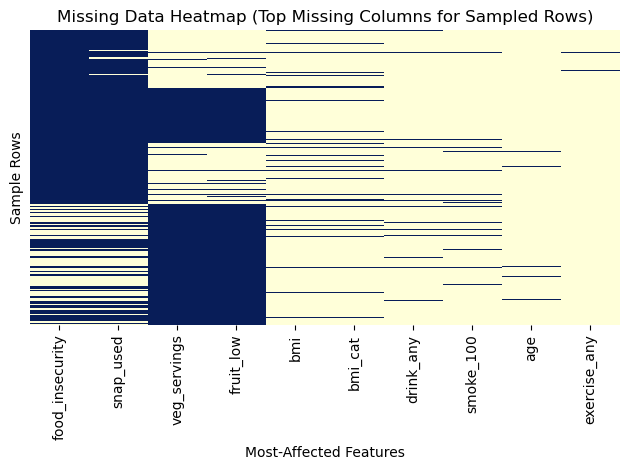

In [6]:
# Filter top N missing columns and show up to 500 rows with missingness
top_missing = missing_summary.sort_values(ascending=False).head(10).index.tolist()
rows_with_missing = df_all[df_all[top_missing].isnull().any(axis=1)]

sns.heatmap(rows_with_missing[top_missing].isnull(), 
            cbar=False, yticklabels=False, cmap="YlGnBu")
plt.title("Missing Data Heatmap (Top Missing Columns for Sampled Rows)")
plt.xlabel("Most-Affected Features")
plt.ylabel("Sample Rows")
plt.tight_layout()
plt.show()

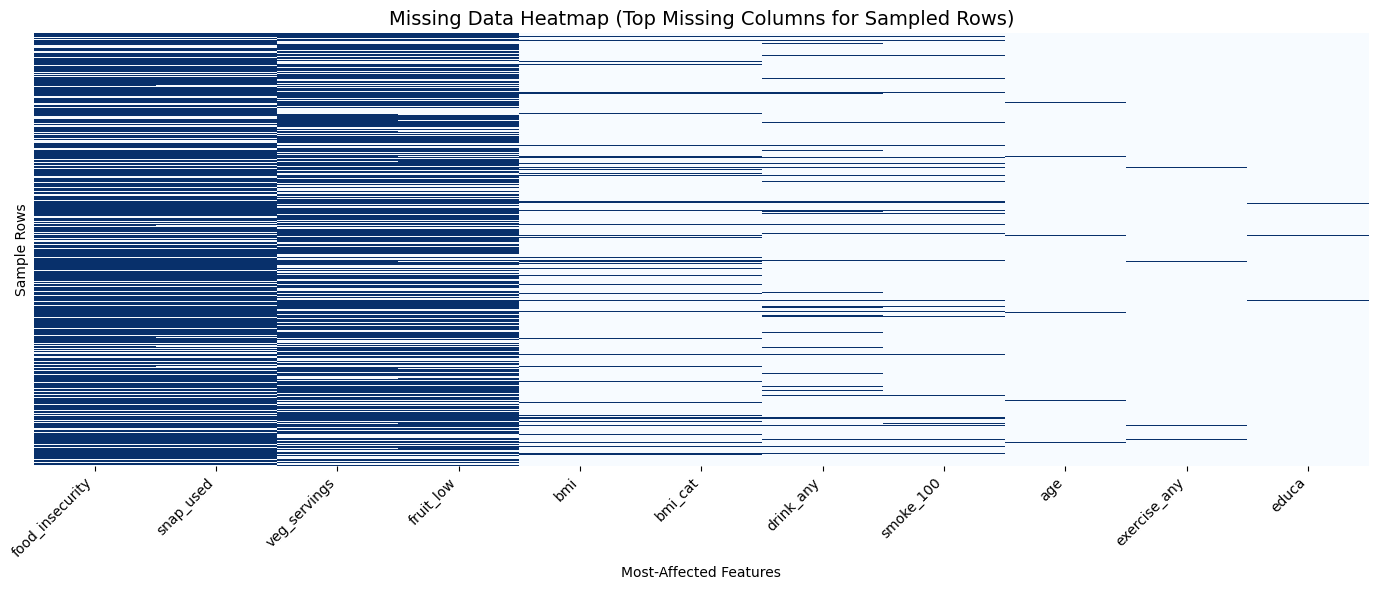

In [7]:
# Rank columns by number of missing values
top_missing_cols = df_all.isnull().sum().sort_values(ascending=False)
columns_to_show = top_missing_cols[top_missing_cols > 0].index.tolist()

# Focus on rows with missing values in these specific columns
subset = df_all[df_all[columns_to_show].isnull().any(axis=1)][columns_to_show]

# Sample to make the plot manageable
subset_sampled = subset.sample(n=min(500, len(subset)), random_state=SEED)

# Plot the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(subset_sampled.isnull(), cmap="Blues", cbar=False,
            yticklabels=False, xticklabels=True)
plt.title("Missing Data Heatmap (Top Missing Columns for Sampled Rows)", fontsize=14)
plt.xlabel("Most-Affected Features")
plt.ylabel("Sample Rows")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Missing Data Heatmap (All Features with Missing Values)

This heatmap visualizes **all features with at least some missing values** in the combined BRFSS dataset from 2019 to 2023. It shows:

- A **random sample of rows** that each contain at least one missing value.
- All **columns that have any non-zero missingness**.

Each dark line indicates a missing value (`NaN`) for that column in that row.

**Key observations:**

- Features like `food_insecurity`, `snap_used`, `veg_servings`, and `fruit_low` have extensive missingness. This reflects the fact that these questions were only included in **some survey years**.
- Other features such as `bmi`, `bmi_cat`, and `drink_any` also show a significant number, though less severe, of missing values.
- A few columns like `age`, `educa`, and `exercise_any` show relatively **light but consistent gaps** across years.

This visualization is especially helpful for spotting **patterns of missingness across features**, which can guide:

- Whether to **include or exclude certain columns** in modeling.
- How to **handle imputation**.
- Whether to **subset the data by year** or harmonize feature availability.

Since this chart includes all affected columns, it provides a comprehensive overview of where missing data might impact downstream analysis.

### 3.2 Target Class Balance

Before modeling, it's also critical to the understand the balance of the target class (`diabetes`) between answers ("Yes" and "No").  We show that by for the dataset as a whole and by year that there is a **7-to-1** proportion between "No" and "Yes".

In [8]:
# Check target class balance
print(df_all["diabetes"].value_counts(normalize=True))

diabetes
No     0.856467
Yes    0.143533
Name: proportion, dtype: float64


In [9]:
# Target counts by year
print(df_all.groupby("year")["diabetes"].value_counts(normalize=True))

year  diabetes
2019  No          0.853427
      Yes         0.146573
2020  No          0.861725
      Yes         0.138275
2021  No          0.859669
      Yes         0.140331
2022  No          0.853632
      Yes         0.146368
2023  No          0.854191
      Yes         0.145809
Name: proportion, dtype: float64


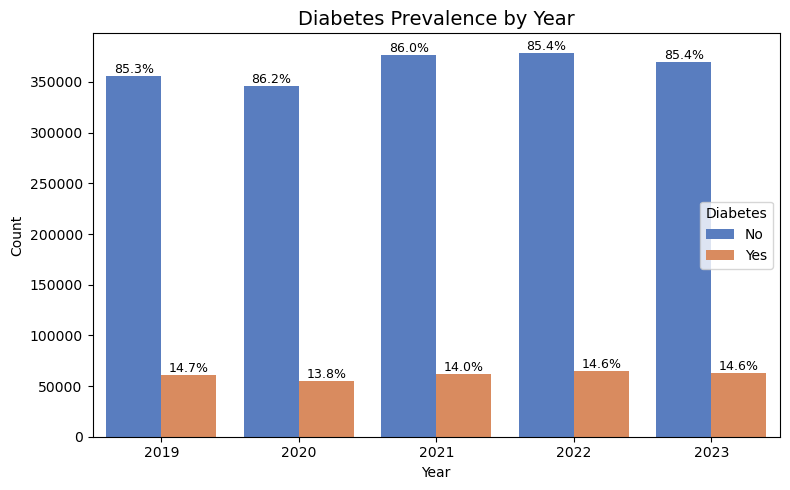

In [10]:
# Make sure 'year' is an integer
df_all["year"] = df_all["year"].astype(int)

# Total counts per year for normalization
total_counts = df_all.groupby("year")["diabetes"].count()

# Plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_all, x="year", hue="diabetes", palette="muted")

# Annotate bars with percentages
xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
for bar in ax.patches:
    height = bar.get_height()
    if height == 0:
        continue  # Skip invisible bars

    x = bar.get_x() + bar.get_width() / 2
    tick_idx = int(round(x))
    if 0 <= tick_idx < len(xtick_labels):
        year_label = int(xtick_labels[tick_idx])
        total = total_counts.get(year_label)
        if total:
            percent = height / total * 100
            ax.annotate(f"{percent:.1f}%",
                        xy=(x, height),
                        ha='center', va='bottom', fontsize=9, color="black")

# Labels and title
plt.title("Diabetes Prevalence by Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Diabetes")
plt.tight_layout()
plt.savefig(image_dir / "diabetes_by_year.png", dpi=300)
plt.show()

The proportion of respondents reporting diabetes ("Yes") remains remarkably stable across all five years, hovering around **14%**, while "No" responses account for approximately **86%**. This suggests consistent prevalence in the sampled population over time.

However, it's important to note that this reflects **self-reported** data from the BRFSS, which may underreport true diabetes prevalence due to undiagnosed cases. The CDC estimates national diabetes prevalence (diagnosed and undiagnosed) to be closer to **11.6%** overall, but higher among older adults — which aligns with the BRFSS's tendency to oversample older respondents.

Given the large sample size (nearly 2.2 million total records), these proportions provide a robust foundation for year-over-year analysis despite minor fluctuations.

## 4. Feature Preparation

### 4.1 Feature Engineering and Encoding

There are only seven features pertinent to diabetes that are common to all the years.

In [11]:
df_model = df_all.copy()

# Include only features common to all years
common_features = ["age", "sex", "educa", "bmi", "bmi_cat", "smoke_100", "exercise_any"]

df_common = df_model.dropna(subset=common_features + ["diabetes"])
df_common = df_common[common_features + ["diabetes"]].copy()

# Convert binary and categorical vars
binary_cols = ["smoke_100", "exercise_any", "diabetes"]
for col in binary_cols:
    df_common[col] = (
        df_common[col]
        .astype(str)
        .str.strip()
        .str.replace('"', "")
        .map({"Yes": 1, "No": 0})
    )

In [12]:
# Convert categorical strings to dummy vars
df_common = pd.get_dummies(
    df_common, columns=["sex", "educa", "bmi_cat"], drop_first=True
)
print(df_common.shape)
print(df_common.head())
print("\nAny NaNs in X?", df_common.drop(columns=["diabetes"]).isna().any().any())

(1842899, 12)
    age    bmi  smoke_100  exercise_any  diabetes  sex_Male  educa_HS or GED  \
0  85.0  28.17          1             0         0     False            False   
1  72.0  18.54          0             1         0     False            False   
2  67.0  31.62          0             1         1     False            False   
4  85.0  21.48          1             0         0     False            False   
6  72.0  32.98          1             1         1      True            False   

   educa_Less than HS  educa_Some college  bmi_cat_Obese  bmi_cat_Overweight  \
0                True               False          False                True   
1               False                True          False               False   
2               False               False           True               False   
4               False                True          False               False   
6               False               False           True               False   

   bmi_cat_Underweight  

## 5. Train/Test Split

In [13]:
# First split features and target
X = df_common.drop(columns=["diabetes"])
y = df_common["diabetes"]

# Then train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

## 6. Logistic Regression Model (for comparison with XGBoost in Notebook 01)

### Why SMOTE?

In this dataset, the number of people who reported being told they had diabetes is much smaller than those who had not — a classic case of **class imbalance**, with only about **1 in 7** representing a postiive diabetes diagnosis. This imbalance can bias a model toward predicting the majority class (“No diabetes”), leading to high overall accuracy but poor detection of the minority class (“Diabetes”).

**SMOTE** (Synthetic Minority Over-sampling Technique) addresses this by generating new, synthetic examples of the minority class. It does this by interpolating between real observations rather than duplicating them, helping the model learn decision boundaries that better reflect both classes.

We apply SMOTE *after* splitting the data into training and testing sets to ensure no data leakage.


In [14]:
print(f"Before SMOTE y_train counts: {y_train.value_counts()}")
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)
print(f"Before SMOTE y_resampled counts: {y_resampled.value_counts()}")

Before SMOTE y_train counts: diabetes
0    1261433
1     212886
Name: count, dtype: int64
Before SMOTE y_resampled counts: diabetes
0    1261433
1    1261433
Name: count, dtype: int64


## 7. Model Evaluation

### 7.1 Precision-Recall Curve

Precision and recall measure two different kinds of model performance:

- **Precision** answers: *Of all the cases the model predicted as positive (diabetes), how many were actually positive?*  
  A low precision means many **false positives** — people incorrectly flagged as having diabetes.

- **Recall** answers: *Of all the actual positive cases (true diabetes), how many did the model correctly identify?*  
  A low recall means many **false negatives** — people with diabetes that the model missed.

These two metrics often trade off against each other depending on the **threshold** we use to convert predicted probabilities into binary decisions. This plot shows how **precision** and **recall** change as we vary the threshold from 0 to 1.

Often the a default threshold of 0.5 is used for the threshold, which can lead to an unintended imbalance between **precision** and **recall**, which we seek to avoid.

The red dot marks the threshold where **precision and recall are approximately equal** (what we might call a **tuned threshold**), representing a balance between false positives and false negatives. This value can serve as a more informative alternative to the default threshold of 0.5, especially when both types of errors are equally important to minimize.


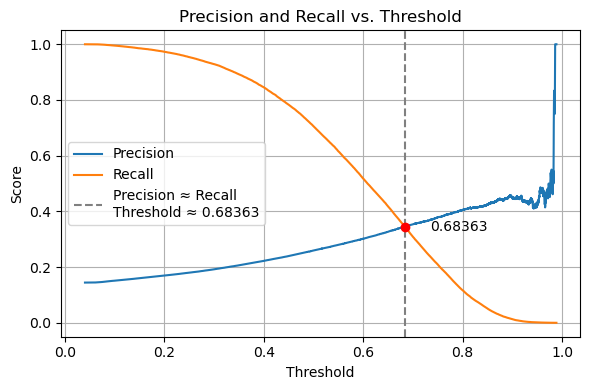

In [15]:
# Predict probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate precision-recall pairs for all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold where precision and recall are closest
pr_diff = np.abs(precision[:-1] - recall[:-1])  # skip last threshold (undefined for precision/recall)
cross_idx = np.argmin(pr_diff)
tuned_threshold = thresholds[cross_idx]

# Apply that tuned threshold to make binary predictions
y_pred_thresh = (y_probs >= tuned_threshold).astype(int)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(
    tuned_threshold,
    linestyle="--",
    color="gray",
    label=f"Precision ≈ Recall\nThreshold ≈ {tuned_threshold:.5f}",
)
plt.scatter([tuned_threshold], [precision[cross_idx]], color="red", zorder=5)

# Annotate the crossover point
plt.text(
    tuned_threshold + 0.05,
    precision[cross_idx],
    f"{tuned_threshold:.5f}",
    color="black",
    fontsize=10,
    va="center",
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(image_dir / "logistic_threshold_crosspoint.png")
plt.show()

We adjust the decision threshold to find the point where precision and recall are approximately equal. This provides a balanced trade-off between false positives and false negatives.

**Precision**: Out of all predicted positives, how many are truly positive.
**Recall**: Out of all actual positives, how many did we correctly identify.
We use a plot to find the threshold where these two scores intersect and define that as our `tuned_threshold`.

### 7.2 Classification Report at Tuned Threshold

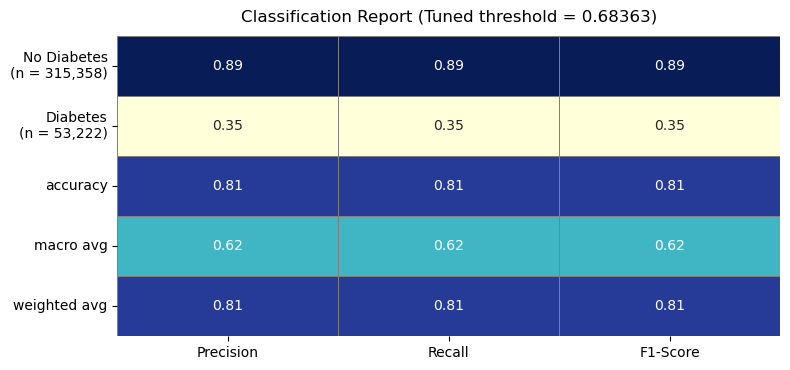

In [16]:
# Generate and format classification report
report_dict = classification_report(y_test, y_pred_thresh, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# Format row labels with support counts
df.rename(index={"0": "No Diabetes", "1": "Diabetes"}, inplace=True)
supports = df.loc[["No Diabetes", "Diabetes"], "support"].dropna().astype(int).map("{:,}".format)
row_labels = {
    label: f"{label}\n(n = {supports[label]})"
    for label in ["No Diabetes", "Diabetes"]
}
# Add other row labels
row_labels["accuracy"] = "accuracy"
row_labels["macro avg"] = "macro avg"
row_labels["weighted avg"] = "weighted avg"

# Select rows and metrics
rows_to_plot = ["No Diabetes", "Diabetes", "accuracy", "macro avg", "weighted avg"]
metrics = df.loc[rows_to_plot, ["precision", "recall", "f1-score"]].round(2)
row_label_list = [row_labels[r] for r in rows_to_plot]

# Plot
fig, ax = plt.subplots(figsize=(8, 3.8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
            linewidths=0.5, linecolor="gray", ax=ax,
            xticklabels=["Precision", "Recall", "F1-Score"],
            yticklabels=row_label_list)

# Final formatting
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title(f"Classification Report (Tuned threshold = {tuned_threshold:.5f})", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig(image_dir / "classification_report_tuned.png", dpi=300)
plt.show()

This heatmap shows the model's classification performance at the tuned threshold of `0.68363`, where precision and recall are approximately equal.

### No Diabetes (majority class, n = 315,358):
- **Precision = 0.89**: When the model predicts "No Diabetes," it's correct 89% of the time.
- **Recall = 0.89**: It correctly identifies 89% of those who actually do not have diabetes.
- **F1-score = 0.89**: Indicates strong and balanced performance on the majority class.

### Diabetes (minority class, n = 53,222):
- **Precision = 0.35**: Only 35% of people predicted to have diabetes actually do — indicating many false positives.
- **Recall = 0.35**: The model identifies 35% of actual diabetes cases, missing most.
- **F1-score = 0.35**: Reflects weak performance on the minority class, which is expected with class imbalance.

---

### Overall Metrics:
- **Accuracy = 0.81**: The model is correct on 81% of predictions, driven mostly by the majority class.
- **Macro Avg = 0.62**: An unweighted average of both classes — shows the drop in minority-class performance.
- **Weighted Avg = 0.81**: Reflects class proportions — dominated by the majority class, similar to overall accuracy.

### Summary:
The model performs well for identifying non-diabetic individuals but struggles to identify diabetes cases. Even with a balanced threshold, the class imbalance remains a challenge. This motivates the use of a more flexible model, such as XGBoost, which we explore in the next notebook.

### 7.3 Confusion Matrix at Tuned Threshold

<Figure size 600x400 with 0 Axes>

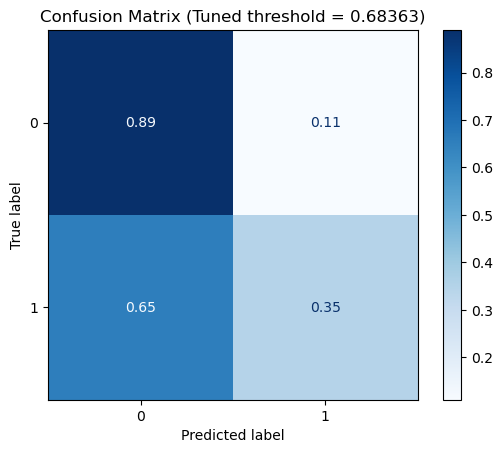

In [17]:
cm = confusion_matrix(y_test, y_pred_thresh, normalize="true")
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format=".2f")
plt.title(f"Confusion Matrix (Tuned threshold = {tuned_threshold:.5f})")
plt.grid(False)
plt.savefig(image_dir / "confusion_matrix_tuned.png")
plt.show();

This normalized confusion matrix shows model performance at the tuned threshold of `0.68363`.

### Top row: True label = No Diabetes
- **89%** were correctly predicted as "No Diabetes" (true negatives).
- **11%** were incorrectly predicted as "Diabetes" (false positives).

### Bottom row: True label = Diabetes
- **35%** were correctly predicted as "Diabetes" (true positives).
- **65%** were incorrectly predicted as "No Diabetes" (false negatives).

### Interpretation:
The model is highly accurate for predicting non-diabetic individuals, but struggles to detect diabetes cases. About two-thirds of people who actually have diabetes are missed by the model — a result of the class imbalance and the model’s limited sensitivity to the minority class. This reinforces the need for a model that can better capture the positive class, especially in a healthcare setting where missing true cases has real consequences.

## 8. Exploring Alternative Thresholds for Different Priorities

The tuned threshold we selected earlier provides a balance between precision and recall, but that balance may not suit all goals. For example, in a **screening scenario**, we might want to identify as many true diabetes cases as possible — even if it means tolerating more false positives.

To explore these trade-offs, we use the **Fβ score**, which allows us to weight recall and precision differently:

- **F2 score** emphasizes **recall** (β = 2). This favors catching more actual diabetes cases (fewer false negatives), at the cost of lower precision.
- **F0.5 score** emphasizes **precision** (β = 0.5). This favors reducing false positives — useful when follow-up testing is costly or invasive.

We'll explore these two threshold strategies in turn.

### 8.1 F2 Threshold (Recall Emphasis)

In [18]:
# Find threshold that maximizes F2 score (recall emphasis)
beta = 2 
f2_scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (beta**2 * precision[:-1] + recall[:-1] + 1e-8)
f2_idx = np.argmax(f2_scores)
f2_threshold = thresholds[f2_idx]
print(f"Best F2 threshold: {f2_threshold:.5f}")

Best F2 threshold: 0.40556


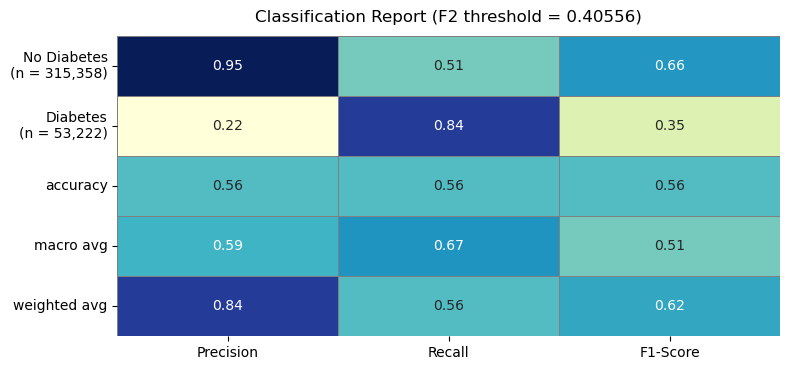

In [19]:
# Define threshold and predictions first
threshold_val = f2_threshold
y_pred_f2 = (y_probs >= threshold_val).astype(int)

report_dict = classification_report(y_test, y_pred_f2, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# Format row labels with support counts
df.rename(index={"0": "No Diabetes", "1": "Diabetes"}, inplace=True)
supports = df.loc[["No Diabetes", "Diabetes"], "support"].dropna().astype(int).map("{:,}".format)
row_labels = {
    label: f"{label}\n(n = {supports[label]})"
    for label in ["No Diabetes", "Diabetes"]
}
row_labels["accuracy"] = "accuracy"
row_labels["macro avg"] = "macro avg"
row_labels["weighted avg"] = "weighted avg"

# Select rows and metrics
rows_to_plot = ["No Diabetes", "Diabetes", "accuracy", "macro avg", "weighted avg"]
metrics = df.loc[rows_to_plot, ["precision", "recall", "f1-score"]].round(2)
row_label_list = [row_labels[r] for r in rows_to_plot]

# Plot
fig, ax = plt.subplots(figsize=(8, 3.8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
            linewidths=0.5, linecolor="gray", ax=ax,
            xticklabels=["Precision", "Recall", "F1-Score"],
            yticklabels=row_label_list)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title(f"Classification Report (F2 threshold = {threshold_val:.5f})", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig(image_dir / "classification_report_f2.png", dpi=300)
plt.show()

This heatmap shows model performance when using the threshold that **maximizes the F2 score**, emphasizing **recall** over precision:

- The model now captures **84%** of actual diabetes cases (recall), a big improvement over the balanced threshold's 35%.
- However, precision for the diabetes class drops to **22%**, meaning most positive predictions are false positives.
- The **No Diabetes** class still has high precision (95%) but recall drops to 51% — many are incorrectly flagged as diabetic.
- **Accuracy drops** to 56%, but this is expected — we've deliberately sacrificed accuracy and precision in order to **catch more true positives**.

This threshold may be useful in **screening scenarios** where missing true cases is riskier than over-diagnosing.

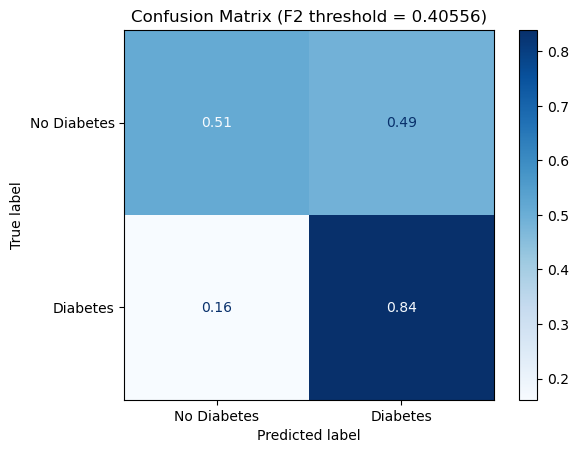

In [20]:
# Confusion matrix at F2 threshold
cm = confusion_matrix(y_test, y_pred_f2, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (F2 threshold = {threshold_val:.5f})")
plt.grid(False)
plt.savefig(image_dir / "cconfusion_matrix_f2.png", dpi=300)
plt.show()

This confusion matrix shows the model’s performance using the F2-optimized threshold, which emphasizes **recall** — prioritizing the identification of as many true diabetes cases as possible.

- Of all actual diabetes cases (bottom row), **84% were correctly identified** (recall), but **16% were missed** (false negatives).
- Among people without diabetes (top row), the model falsely flagged **49%** as diabetic (false positives), reflecting the trade-off in precision.

This threshold may be appropriate for **screening scenarios**, where missing true cases is more costly than generating some false alarms.

### 8.2 F05 Threshold (Precision Emphasis)

In [21]:
# precision emphasis
beta = 0.5
f05_scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (beta**2 * precision[:-1] + recall[:-1] + 1e-8)
f05_idx = np.argmax(f05_scores)
f05_threshold = thresholds[f05_idx]
print(f"Best F0.5 threshold: {f05_threshold:.5f}")

Best F0.5 threshold: 0.68627


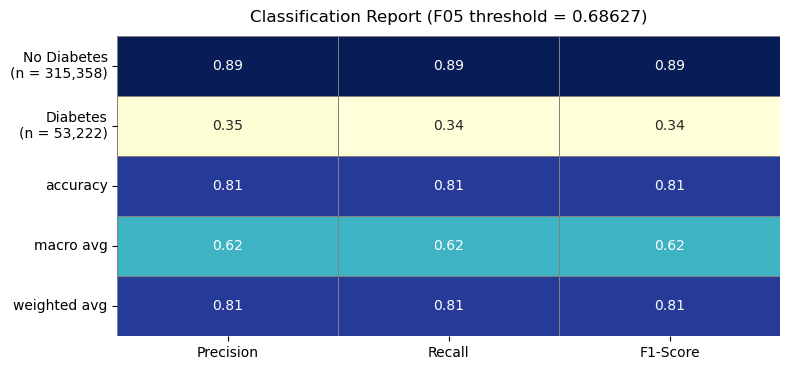

In [22]:
# Define threshold and predictions first
threshold_val = f05_threshold
y_pred_f05 = (y_probs >= threshold_val).astype(int)

report_dict = classification_report(y_test, y_pred_f05, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# Format row labels with support counts
df.rename(index={"0": "No Diabetes", "1": "Diabetes"}, inplace=True)
supports = df.loc[["No Diabetes", "Diabetes"], "support"].dropna().astype(int).map("{:,}".format)
row_labels = {
    label: f"{label}\n(n = {supports[label]})"
    for label in ["No Diabetes", "Diabetes"]
}
row_labels["accuracy"] = "accuracy"
row_labels["macro avg"] = "macro avg"
row_labels["weighted avg"] = "weighted avg"

# Select rows and metrics
rows_to_plot = ["No Diabetes", "Diabetes", "accuracy", "macro avg", "weighted avg"]
metrics = df.loc[rows_to_plot, ["precision", "recall", "f1-score"]].round(2)
row_label_list = [row_labels[r] for r in rows_to_plot]

# Plot
fig, ax = plt.subplots(figsize=(8, 3.8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
            linewidths=0.5, linecolor="gray", ax=ax,
            xticklabels=["Precision", "Recall", "F1-Score"],
            yticklabels=row_label_list)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title(f"Classification Report (F05 threshold = {threshold_val:.5f})", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig(image_dir / "classification_report_f05.png", dpi=300)
plt.show()

This classification report reflects the model's performance using the **F0.5-optimized threshold**, which favors **precision** — reducing the number of false positives, even if it means missing some true cases.

- For the **Diabetes** class, precision is **0.35**, meaning just over one-third of predicted positives are truly diabetic.
- Recall remains modest at **0.34**, suggesting that many diabetes cases are still being missed.
- These values are nearly identical to the balanced threshold from earlier, showing that the F0.5-optimal threshold (≈ 0.686) closely aligns with the threshold where precision and recall intersect.

This threshold may be suitable in contexts where false positives are costly — for example, if follow-up testing is expensive or invasive — but it offers **no clear performance gain** over the balanced threshold.

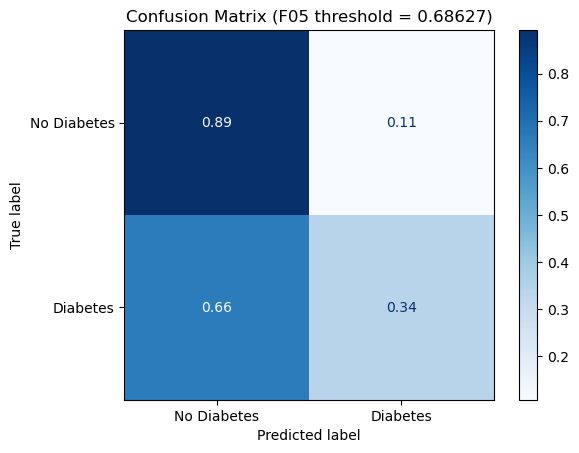

In [23]:
# Confusion matrix at F05 threshold
cm = confusion_matrix(y_test, y_pred_f05, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (F05 threshold = {threshold_val:.5f})")
plt.grid(False)
plt.savefig(image_dir / "cconfusion_matrix_f05.png", dpi=300)
plt.show()

This confusion matrix reflects model behavior at the **F0.5-optimized threshold**, which favors **precision** over recall.

- The model correctly identifies **89%** of people who do **not** have diabetes (true negatives), while misclassifying **11%** of them as diabetic (false positives).
- For the minority class (**Diabetes**), the model correctly flags only **34%** of cases, missing **66%** — a significant drop in sensitivity.

Although this threshold slightly reduces false positives compared to a recall-focused threshold, it comes at the cost of failing to detect the majority of true diabetes cases. This makes it a poor choice for **screening purposes**, where **recall matters most**.

## 9. Comparing Threshold Trade-Offs Visually

This chart visualizes how **precision** and **recall** change continuously as we adjust the classification threshold from 0 to 1.

- **Precision** improves with higher thresholds: fewer false positives.
- **Recall** declines: more true cases are missed.
- The **green line** marks the F2-optimal threshold — prioritizing recall.
- The **purple line** marks the F0.5-optimal threshold — prioritizing precision.

This plot illustrates the **inherent trade-off**: we can't maximize both metrics simultaneously. Instead, we must choose based on **application needs** — whether it's more costly to miss cases (recall) or raise false alarms (precision).


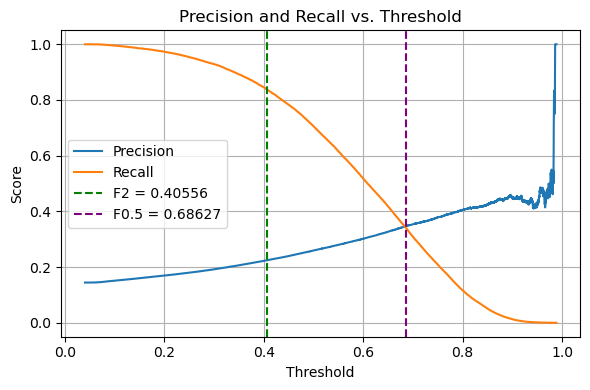

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

plt.axvline(f2_threshold, color="green", linestyle="--", label=f"F2 = {f2_threshold:.5f}")
plt.axvline(f05_threshold, color="purple", linestyle="--", label=f"F0.5 = {f05_threshold:.5f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(image_dir / "precision_recall_vs_threshold.png", dpi=300)
plt.show()

This chart shows how **precision** and **recall** vary as the classification **threshold** changes.

- As the threshold increases (moving right), **precision** improves (fewer false positives), but **recall** drops (more missed true positives).
- The **green dashed line** marks the **F2-optimized threshold**, which emphasizes **recall** — favoring sensitivity to true cases.
- The **purple dashed line** marks the **F0.5-optimized threshold**, which emphasizes **precision** — favoring accuracy over sensitivity.

This visual reinforces that there’s no “best” threshold for all contexts. The choice depends on whether you care more about avoiding missed cases (recall) or false alarms (precision).

## 10. Visualizing Overall Model Performance: ROC Curve

While we've examined model performance at specific thresholds, the **Receiver Operating Characteristic (ROC) curve** summarizes the model's performance across all possible thresholds.

The **AUC (Area Under the Curve)** gives a single-value summary:
- AUC = 0.5: no better than random guessing
- AUC = 1.0: perfect classification

The curve below shows how well the logistic regression model distinguishes between diabetic and non-diabetic cases overall.

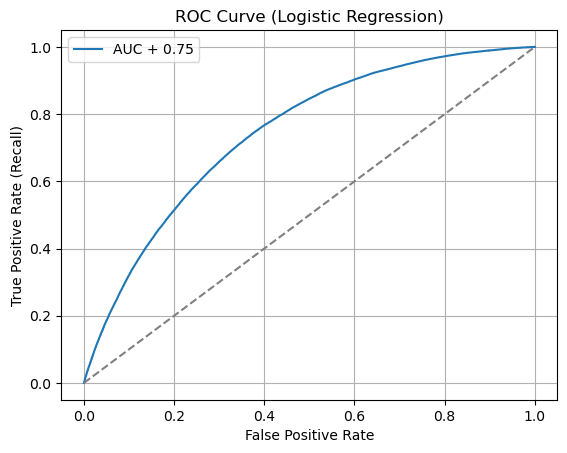

In [25]:
# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC + {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.savefig(image_dir / "roc_curve.png", dpi=300)
plt.show()

The ROC curve summarizes how well the model distinguishes between diabetic and non-diabetic cases across all thresholds.

- The **True Positive Rate (Recall)** is plotted against the **False Positive Rate**.
- The diagonal line represents random guessing (AUC = 0.5).
- Our logistic regression model achieves an **AUC of ~0.75**, indicating a moderate ability to distinguish between classes.

This suggests that while logistic regression performs better than chance, it may not be adequate for high-stakes applications like diabetes screening — especially under class imbalance.


In [26]:
time_spent = (time.time() - start_time) / 60

print(f"Notebook time: {time_spent:.2f} minutes")

Notebook time: 1.78 minutes


### 11. Summary and Next Steps

We evaluated logistic regression under three different decision thresholds:

| Strategy           | Precision (Diabetes) | Recall (Diabetes) | Use Case                                      |
|--------------------|----------------------|--------------------|-----------------------------------------------|
| **Balanced (Tuned)** | ~0.35               | ~0.35               | When false positives and false negatives are equally costly |
| **F2 Threshold**     | ~0.22               | **~0.84**           | When **missing cases is more dangerous**, e.g., early screening |
| **F0.5 Threshold**   | **~0.35**           | ~0.34               | When **false alarms are costly**, e.g., expensive follow-up testing |

Each threshold supports a different real-world goal.

Despite tuning, **logistic regression struggles to detect diabetes cases reliably**, especially in imbalanced data. In the next notebook, we’ll apply **XGBoost**, a gradient-boosted tree model that handles class imbalance and feature interactions more effectively.

See `01_xgboost_2022_2023.ipynb` for our next modeling experiment.
